In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('data/501_NO.csv')

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

start_date = '2023-2-28 00:00:00'
end_date = '2023-3-28 00:00:00'

filter = (df['DATE_TIME'].between(start_date, end_date))

df = df.loc[filter]

df.set_index('DATE_TIME', inplace=True)

ts = df['NO']

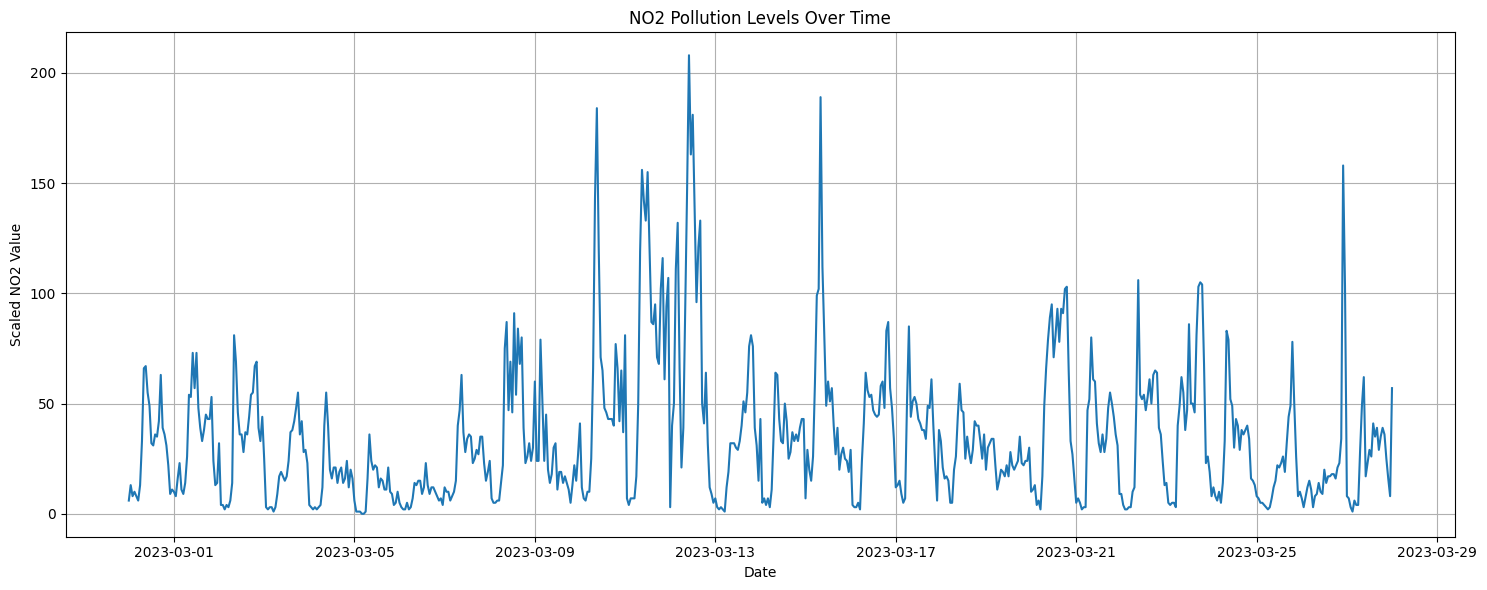

In [3]:
plt.figure(figsize=(15, 6))
plt.plot(df)
plt.title('NO2 Pollution Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled NO2 Value')
plt.grid(True)
plt.tight_layout()

In [4]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("Result: The series is stationary.")
    else:
        print("Result: The series is NOT stationary.")

print("ADF Test on Original Data:")
adf_test(ts)

ADF Test on Original Data:
ADF Statistic: -8.901728
p-value: 0.000000
Result: The series is stationary.


In [5]:
# ts_seasonal_diff = ts.diff(168).dropna()

# ts_diff = ts_seasonal_diff.diff().dropna()

# print("\nADF Test after Differencing:")
# adf_test(ts_diff)

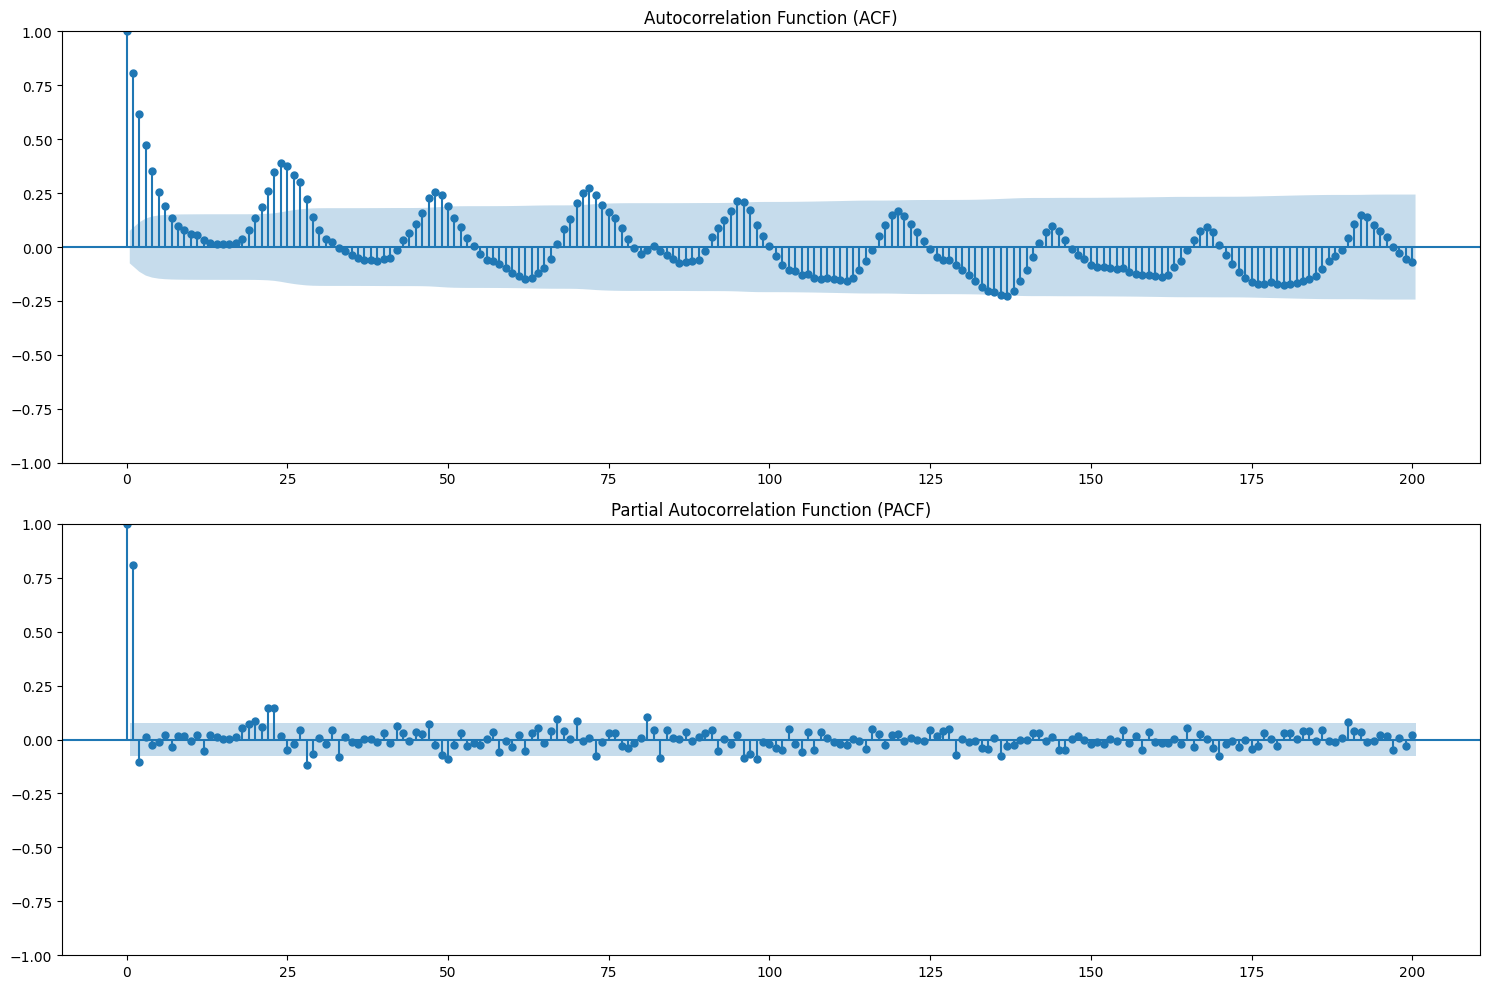

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

sm.graphics.tsa.plot_acf(ts, lags=200, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

sm.graphics.tsa.plot_pacf(ts, lags=200, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [7]:
# model = pm.auto_arima(ts,
#                       m=35,
#                       seasonal=True,
#                       stepwise=True,
#                       suppress_warnings=True,
#                       D=1,
#                       max_order=10)


# print(model.summary())

In [8]:
train_size = int(len(ts) * 0.85)  
train_data = ts[:train_size]
test_data = ts[train_size:]

order = (1, 0, 0)
seasonal_order = (2, 1, 0, 168)

print("\nBuilding and training the SARIMA model...")
model = SARIMAX(train_data,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print("\nSARIMA Model Summary:")
print(results.summary())


Building and training the SARIMA model...


c:\Users\jaydn\Documents\Projects\Polution-ARIMA-Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jaydn\Documents\Projects\Polution-ARIMA-Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



SARIMA Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                                  NO   No. Observations:                  572
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 168)   Log Likelihood                -280.421
Date:                             Fri, 29 Aug 2025   AIC                            568.842
Time:                                     18:18:33   BIC                            577.661
Sample:                                 02-28-2023   HQIC                           572.332
                                      - 03-23-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6467      0.117      5.543      0.000       0.418       0.875
ar.S

Mean Absolute Error (MAE): 16.79
Mean Squared Error (MSE): 733.34
Root Mean Squared Error (RMSE): 27.08


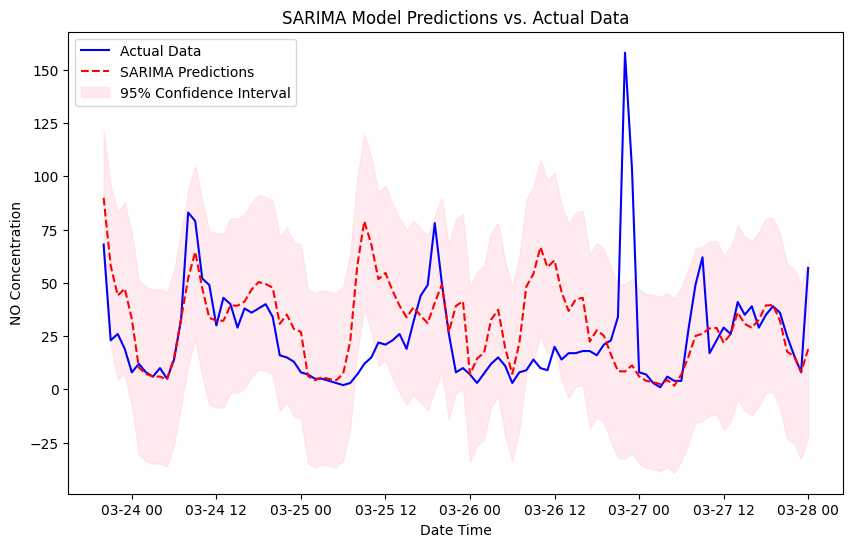

In [9]:
predictions = results.get_prediction(start=len(train_data), end=len(ts)-1, dynamic=False)
predicted_values = predictions.predicted_mean

mae = mean_absolute_error(test_data, predicted_values)
mse = mean_squared_error(test_data, predicted_values)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

pred_ci = predictions.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual Data', color='blue')
plt.plot(predicted_values.index, predicted_values.values, label='SARIMA Predictions', color='red', linestyle='--')

plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMA Model Predictions vs. Actual Data')
plt.xlabel('Date Time')
plt.ylabel('NO Concentration')
plt.legend()
plt.show()